In [1]:
from PIL import Image
import cv2
import torch
import math 
import function.utils_rotate as utils_rotate
from IPython.display import display
import os
import function.helper as helper

In [2]:
# load yolo model for detect and character detection stage
# please download yolov5 from our link on github
yolo_LP_detect = torch.hub.load('yolov5', 'custom', path='model/LP_detector.pt', force_reload=True, source='local')
yolo_license_plate = torch.hub.load('yolov5', 'custom', path='model/LP_ocr.pt', force_reload=True, source='local')

# set model confidence threshold 
# yolo_LP_detect.conf = 0.6
yolo_license_plate.conf = 0.60

d:\Nam4\License-Plate-Recognition\yolov5\utils\general.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
YOLOv5  v6.1-179-gf3fecf94 torch 2.9.1+cpu CPU

YOLOv5  v6.1-179-gf3fecf94 torch 2.9.1+cpu CPU

Fusing layers... 
Fusing layers... 
Model summary: 290 layers, 20852934 parameters, 0 gradients
Adding AutoShape... 
Model summary: 290 layers, 20852934 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  v6.1-179-gf3fecf94 torch 2.9.1+cpu CPU

YOLOv5  v6.1-179-gf3fecf94 torch 2.9.1+cpu CPU

Fusing layers... 
Fusing layers... 
Model summary: 290 layers, 20970123 parameters, 0 gradients
Adding AutoShape... 
Model summary: 290 layers, 20970123 parameters, 0 gradients
Adding AutoShape... 


In [3]:
#enter image path here
img_file = "test_image/license_2.png"
img = cv2.imread(img_file)
plates = yolo_LP_detect(img, size=640)

d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [4]:
list_plates = plates.pandas().xyxy[0].values.tolist()
list_read_plates = set()
count = 0
if len(list_plates) == 0:
    lp = helper.read_plate(yolo_license_plate,img)
    if lp != "unknown":
        list_read_plates.add(lp)
else:
    for plate in list_plates:
        flag = 0
        x = int(plate[0]) # xmin
        y = int(plate[1]) # ymin
        w = int(plate[2] - plate[0]) # xmax - xmin
        h = int(plate[3] - plate[1]) # ymax - ymin  
        crop_img = img[y:y+h, x:x+w]
        cv2.rectangle(img, (int(plate[0]),int(plate[1])), (int(plate[2]),int(plate[3])), color = (0,0,225), thickness = 2)
        cv2.imwrite("crop.jpg", crop_img)
        rc_image = cv2.imread("crop.jpg")
        lp = ""
        count+=1
        for cc in range(0,2):
            for ct in range(0,2):
                lp = helper.read_plate(yolo_license_plate, utils_rotate.deskew(crop_img, cc, ct))
                if lp != "unknown":
                    list_read_plates.add(lp)
                    flag = 1
                    break
            if flag == 1:
                break

d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

{'51G21670', '51F31118', '51G31691', '51G51008', '51F35613'}


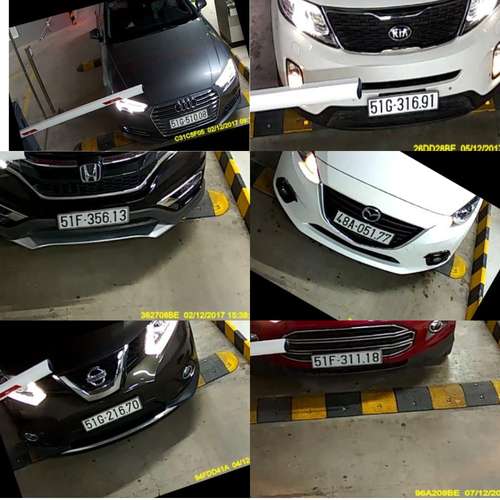

In [5]:
print(list_read_plates)
img = Image.open(img_file)
basewidth = 500
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth, hsize), Image.Resampling.LANCZOS)
display(img)

In [8]:
import os
import cv2
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import pandas as pd

image_dir = "data/test/"
results = []

for img_name in os.listdir(image_dir):
    if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        continue
    
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)
    plates = yolo_LP_detect(img, size=640)
    list_plates = plates.pandas().xyxy[0].values.tolist()
    
    has_detection = len(list_plates) > 0  # Có phát hiện bounding box không
    pred_label = "unknown"
    
    if len(list_plates) == 0:
        pred_label = helper.read_plate(yolo_license_plate, img)
    else:
        for plate in list_plates:
            x = int(plate[0])
            y = int(plate[1])
            w = int(plate[2] - plate[0])
            h = int(plate[3] - plate[1])
            crop_img = img[y:y+h, x:x+w]
            pred_label = helper.read_plate(yolo_license_plate, crop_img)
            if pred_label != "unknown":
                break
    
    recognized = pred_label != "unknown"  # Có đọc được text không
    
    # Phân loại trạng thái
    if not has_detection:
        status = "Không phát hiện"
    elif not recognized:
        status = "Phát hiện nhưng đọc sai (hoặc phát hiện sai vị trí)"
    else:
        status = "Thành công"
    
    # Lưu kết quả
    results.append({
        'image': img_name,
        'has_detection': has_detection,
        'recognized': recognized,
        'predicted_text': pred_label,
        'num_plates': len(list_plates),
        'status': status
    })

# Tạo DataFrame để phân tích
df = pd.DataFrame(results)

# Tính các chỉ số
total_images = len(df)
num_has_detection = df['has_detection'].sum()
num_recognized = df['recognized'].sum()
num_no_detection = sum(~df['has_detection'])
num_detected_but_failed = sum(df['has_detection'] & ~df['recognized'])

detection_rate = (num_has_detection / total_images * 100) if total_images > 0 else 0
recognition_rate = (num_recognized / total_images * 100) if total_images > 0 else 0

print("=" * 70)
print("KẾT QUẢ ĐÁNH GIÁ HỆ THỐNG NHẬN DIỆN BIỂN SỐ XE")
print("=" * 70)
print(f"{'CHỈ SỐ ĐÁNH GIÁ':<40} {'GIÁ TRỊ':<15} {'GHI CHÚ'}")
print("-" * 70)
print(f"{'Tổng số ảnh đánh giá':<40} {total_images:<15} {'-'}")
print(f"{'Số ảnh có phát hiện bounding box':<40} {num_has_detection:<15} {'Model tìm thấy vùng'}")
print(f"{'Số ảnh nhận diện thành công':<40} {num_recognized:<15} {'Phát hiện và đọc đúng'}")
print(f"{'Số ảnh không phát hiện được':<40} {num_no_detection:<15} {'Không tìm thấy bounding box'}")
print(f"{'Số ảnh phát hiện nhưng đọc sai':<40} {num_detected_but_failed:<15} {'Có bbox nhưng OCR fail'}")
print("-" * 70)
print(f"{'Detection Rate':<40} {detection_rate:.2f}%{' ':<10} {'Tỷ lệ phát hiện bbox'}")
print(f"{'Recognition Rate':<40} {recognition_rate:.2f}%{' ':<10} {'Tỷ lệ nhận diện tổng thể'}")
print("=" * 70)

# Lưu kết quả chi tiết ra file CSV
df.to_csv('evaluation_results.csv', index=False, encoding='utf-8-sig')
print(f"\nĐã lưu kết quả chi tiết vào file: evaluation_results.csv")

# Hiển thị thống kê theo trạng thái
print("\n" + "=" * 70)
print("PHÂN LOẠI THEO TRẠNG THÁI:")
print("=" * 70)
status_counts = df['status'].value_counts()
for status, count in status_counts.items():
    print(f"{status:<45} {count:>5} ảnh ({count/total_images*100:.2f}%)")

# Hiển thị một số trường hợp từng loại
print("\n" + "=" * 70)
print("MỘT SỐ TRƯỜNG HỢP KHÔNG PHÁT HIỆN ĐƯỢC:")
print("=" * 70)
no_detection = df[~df['has_detection']].head(5)
for idx, row in no_detection.iterrows():
    print(f"{row['image']:<40} - {row['status']}")

print("\n" + "=" * 70)
print("MỘT SỐ TRƯỜNG HỢP PHÁT HIỆN NHƯNG ĐỌC SAI:")
print("=" * 70)
detected_failed = df[df['has_detection'] & ~df['recognized']].head(10)
for idx, row in detected_failed.iterrows():
    print(f"{row['image']:<40} - Số bbox: {row['num_plates']}")

d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

KẾT QUẢ ĐÁNH GIÁ HỆ THỐNG NHẬN DIỆN BIỂN SỐ XE
CHỈ SỐ ĐÁNH GIÁ                          GIÁ TRỊ         GHI CHÚ
----------------------------------------------------------------------
Tổng số ảnh đánh giá                     838             -
Số ảnh có phát hiện bounding box         823             Model tìm thấy vùng
Số ảnh nhận diện thành công              666             Phát hiện và đọc đúng
Số ảnh không phát hiện được              15              Không tìm thấy bounding box
Số ảnh phát hiện nhưng đọc sai           157             Có bbox nhưng OCR fail
----------------------------------------------------------------------
Detection Rate                           98.21%           Tỷ lệ phát hiện bbox
Recognition Rate                         79.47%           Tỷ lệ nhận diện tổng thể

Đã lưu kết quả chi tiết vào file: evaluation_results.csv

PHÂN LOẠI THEO TRẠNG THÁI:
Thành công                                      666 ảnh (79.47%)
Phát hiện nhưng đọc sai (hoặc phát hiện sai vị trí)  

MẪU ẢNH NHẬN DIỆN THÀNH CÔNG:


d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



boderngoaigiao3.jpg - Nhận diện: 17E1NG01


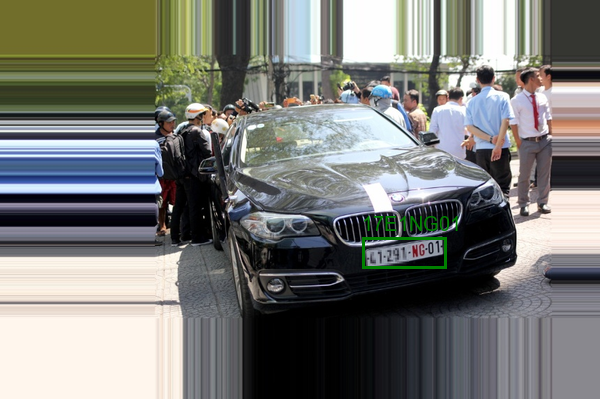

d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



boderngoaigiao5.jpg - Nhận diện: 41501MDD8


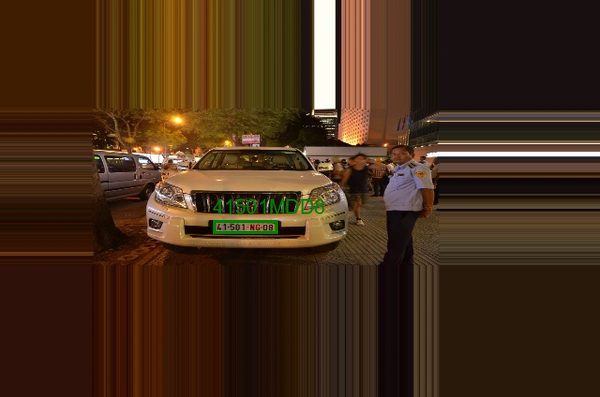

d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



brightnessngoaigiao5.jpg - Nhận diện: 41501NG08


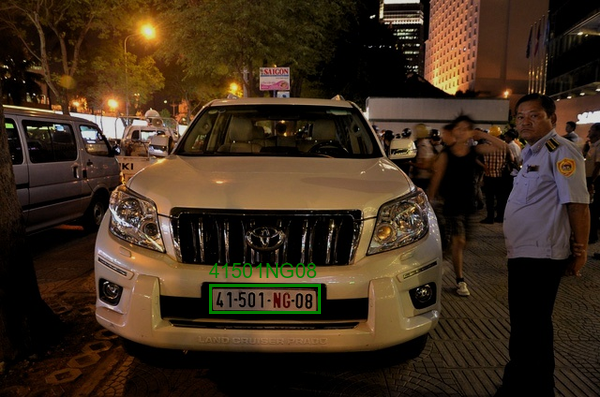


MẪU ẢNH NHẬN DIỆN THẤT BẠI:


d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



boderngoaigiao1.jpg - Phát hiện nhưng đọc sai


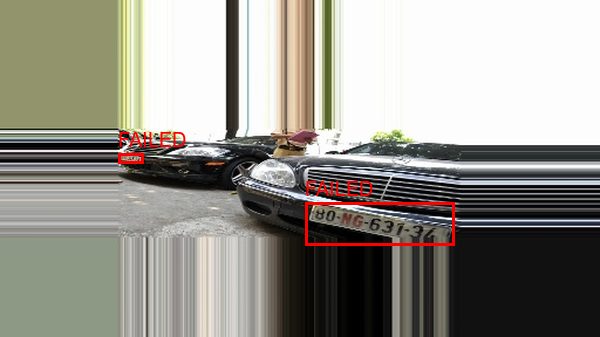

d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



boderngoaigiao9.jpg - Phát hiện nhưng đọc sai


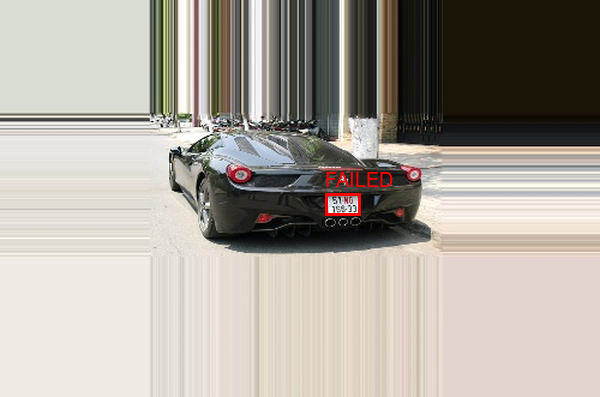

d:\Nam4\License-Plate-Recognition\yolov5\models\common.py:565: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



boderquandoi1.jpg - Phát hiện nhưng đọc sai


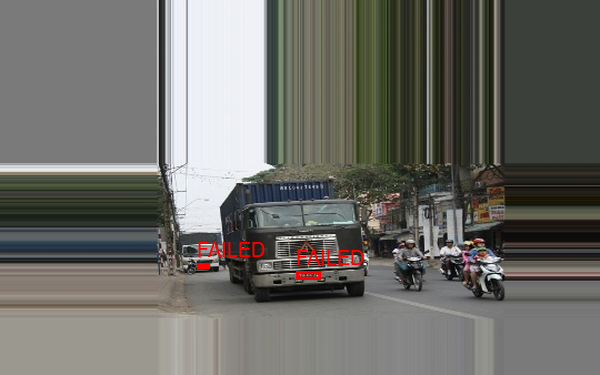

In [15]:
# Hiển thị mẫu ảnh để kiểm tra chi tiết
# Chọn hiển thị 5 ảnh thành công và 5 ảnh thất bại

from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

def show_sample_images(df, num_success=5, num_fail=5):
    """Hiển thị mẫu ảnh thành công và thất bại"""
    
    print("=" * 60)
    print("MẪU ẢNH NHẬN DIỆN THÀNH CÔNG:")
    print("=" * 60)
    
    success_cases = df[df['recognized']].head(num_success)
    for idx, row in success_cases.iterrows():
        img_path = os.path.join(image_dir, row['image'])
        img_cv = cv2.imread(img_path)
        plates = yolo_LP_detect(img_cv, size=640)
        list_plates = plates.pandas().xyxy[0].values.tolist()
        
        # Mở ảnh bằng PIL để vẽ
        img_pil = Image.open(img_path)
        orig_w, orig_h = img_pil.size
        
        # Resize để hiển thị
        basewidth = 600
        wpercent = (basewidth/float(orig_w))
        hsize = int((float(orig_h)*float(wpercent)))
        img_display = img_pil.resize((basewidth, hsize), Image.Resampling.LANCZOS)
        
        # Vẽ bounding box và text
        draw = ImageDraw.Draw(img_display)
        try:
            font = ImageFont.truetype("arial.ttf", 20)
        except:
            font = ImageFont.load_default()
        
        for plate in list_plates:
            x1 = int(plate[0] * basewidth / orig_w)
            y1 = int(plate[1] * hsize / orig_h)
            x2 = int(plate[2] * basewidth / orig_w)
            y2 = int(plate[3] * hsize / orig_h)
            draw.rectangle([x1, y1, x2, y2], outline="green", width=3)
            draw.text((x1, y1-25), row['predicted_text'], fill="green", font=font)
        
        print(f"\n{row['image']} - Nhận diện: {row['predicted_text']}")
        display(img_display)
    
    print("\n" + "=" * 60)
    print("MẪU ẢNH NHẬN DIỆN THẤT BẠI:")
    print("=" * 60)
    
    fail_cases = df[~df['recognized']].head(num_fail)
    for idx, row in fail_cases.iterrows():
        img_path = os.path.join(image_dir, row['image'])
        img_cv = cv2.imread(img_path)
        plates = yolo_LP_detect(img_cv, size=640)
        list_plates = plates.pandas().xyxy[0].values.tolist()
        
        # Mở ảnh bằng PIL để vẽ
        img_pil = Image.open(img_path)
        orig_w, orig_h = img_pil.size
        
        # Resize để hiển thị
        basewidth = 600
        wpercent = (basewidth/float(orig_w))
        hsize = int((float(orig_h)*float(wpercent)))
        img_display = img_pil.resize((basewidth, hsize), Image.Resampling.LANCZOS)
        
        # Vẽ bounding box nếu có
        draw = ImageDraw.Draw(img_display)
        try:
            font = ImageFont.truetype("arial.ttf", 20)
        except:
            font = ImageFont.load_default()
        
        for plate in list_plates:
            x1 = int(plate[0] * basewidth / orig_w)
            y1 = int(plate[1] * hsize / orig_h)
            x2 = int(plate[2] * basewidth / orig_w)
            y2 = int(plate[3] * hsize / orig_h)
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
            draw.text((x1, y1-25), "FAILED", fill="red", font=font)
        
        status = "Không phát hiện biển số" if not row['has_detection'] else "Phát hiện nhưng đọc sai"
        print(f"\n{row['image']} - {status}")
        display(img_display)

# Gọi hàm hiển thị
show_sample_images(df, num_success=3, num_fail=3)